# Análisis Exploratorio de Datos (EDA) – Instagram Analytics Dataset

**Autor:** _Carlos Checa Moreno_  

En este notebook realizo un análisis exploratorio inicial (EDA) del dataset
**"[Maddison Project Dataset 2020 Raw](https://www.kaggle.com/datasets/mathurinache/maddison-project-dataset-2020-raw)"** obtenido de Kaggle.

El objetivo es:

1. Cargar el dataset.
2. Explorar su estructura y calidad.
3. Realizar tareas básicas de limpieza y normalización.
4. Generar visualizaciones sencillas que ayuden a entender los datos.
5. Resumir las conclusiones principales del análisis exploratorio.

---


# 1. Cargar el Dataset.

Para encontrar un dataset adecuado para esta primera práctica, he buscado "raw data" en Kaggle y he podido encontrar el dataset Maddison Project Dataset 2020 Raw. Este dataset nos presenta varios retos como valores nulos, fechas, no existe una variable indentificadora por sí misma y tenemos columnas que nos dan la misma información. Trataré todos estos problemas en los siguientes puntos.

A parte, para que suponga un mayor reto, añadiré registros duplicados manualmente los cuales tendrán también valores faltantes. Obviamente esto se realizará únicamente con fines académicos para poner en práctica todos los conocimientos posibles adquiridos en estas semanas del máster.

Empezando con el código, cargo el dataset directamente de Kaggle.

In [246]:
# Imports para acceder al dataset y cargarlo en un dataframe
import os
import pandas as pd

## 1.1. Importar Dataset

### 1.1.1. Cargar el dataset desde Kaggle

In [247]:
import kagglehub

path = kagglehub.dataset_download("mathurinache/maddison-project-dataset-2020-raw")
print("Ruta de los ficheros del dataset:", path)
os.listdir(path)

# Cargo el dataset en un dataframe de pandas
nombre_fichero = "Maddison Project Dataset 2020 Raw.csv"
ruta_csv = os.path.join(path, nombre_fichero)
df = pd.read_csv(ruta_csv)

Ruta de los ficheros del dataset: C:\Users\carlo\.cache\kagglehub\datasets\mathurinache\maddison-project-dataset-2020-raw\versions\1


### 1.1.2. Cargar el dataset desde la carpeta

In [248]:
ruta_csv = "../data/dataset.csv"
df = pd.read_csv(ruta_csv)

## 1.2. Revisar dimensiones y primeras filas

El dataset está compuesto por las siguientes variables:
*   countrycode: Código abreviado (3 letras) que identifica al país.
*   country: Nombre del país al que pertenece la observación.
*   year: Año al que se refiere el dato económico y demográfico.
*   gdppc: Producto interior bruto por persona.
*   pop: Población total del país en ese año.

Observamos que **no encontrarmos ninguna variable identificativa** por sí misma. Para identificar cada registro usaremos la agregación de las columnas countrycode + year o country + year, pues sabemos que solo tendremos una medción máxima por cada año para cada país.

In [249]:
print("Dimensiones del dataframe:", df.shape)
df.head()

Dimensiones del dataframe: (21682, 5)


,countrycode,country,year,gdppc,pop
0,AFG,Afghanistan,1820,NaN,3 280
1,AFG,Afghanistan,1870,NaN,4 207
2,AFG,Afghanistan,1913,NaN,5 730
3,AFG,Afghanistan,1950,1 156,8 150
4,AFG,Afghanistan,1951,1 170,8 284


## 1.3. Inspeccionar tipos de datos

In [250]:
print(df.dtypes, "\n")
df.info()


countrycode    object
country        object
year            int64
gdppc          object
pop            object
dtype: object 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21682 entries, 0 to 21681
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   countrycode  21682 non-null  object
 1   country      21682 non-null  object
 2   year         21682 non-null  int64 
 3   gdppc        19706 non-null  object
 4   pop          17199 non-null  object
dtypes: int64(1), object(4)
memory usage: 847.1+ KB


Gracias a esta información sabemos que tenemos 21 682 filas. Las columnas de PIB per cápita (gdppc) y población (pop) tienen valores faltantes (en el siguiente punto abordaremos más en profundidad este tema) y además están como object, así que será necesario convertirlos a variables numéricas para analizarlas adecuadamente.

# 2. Explorar su Estructura y Calidad.

Antes de empezar a corregir el dataset, voy a introducir algunos registros duplicados con valores faltantes. Esto lo haré unicamente con fines académicos para poder aplicar todos los conocimientos posibles adquiridos durante estas primeras semanas del máster. 

De base este dataset sí contiene valores faltantes, pero no duplicados. De ahí esta decisión de aumentar la dificultad a la hora de formatear el dataset.

In [251]:
import numpy as np

n_dup = min(500, len(df)) 
df_dup = df.sample(n=n_dup, replace=False).copy()
cols_objetivo = df_dup.columns
col_aleatoria_por_fila = np.random.choice(cols_objetivo, size=len(df_dup))
for i, col in enumerate(col_aleatoria_por_fila):
    idx = df_dup.index[i]
    df_dup.loc[idx, col] = np.nan
df = pd.concat([df, df_dup], ignore_index=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22182 entries, 0 to 22181
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   countrycode  22079 non-null  object 
 1   country      22090 non-null  object 
 2   year         22064 non-null  float64
 3   gdppc        20079 non-null  object 
 4   pop          17527 non-null  object 
dtypes: float64(1), object(4)
memory usage: 866.6+ KB


Aquí es interesante observar como la columna year cambia del tipo int64 a float64. Esto sucede porque el tipo int64 no admite NaN, por esto pandas convierte este tipo a float para poder guardas el Nan. 

En otras palabras, como vimos en el punto 1.3 la columna year no tenía valores faltantes. Al insertar valores faltantes en esta dimensión, es necesario cambiar el dominio de dicha variable par que admita el valor faltante.

## 2.1. Valores nulos.

In [252]:
# Defino como función porque reutilizaré en el punto 3.2. Tratamiento de nulos.
# Y devuelvo null_-counts y null_percent por también las utilizaré en el punto citado.
def valoresNulos():
    # Valores nulos por columna: conteo y porcentaje
    null_counts = df.isna().sum()
    null_percent = df.isna().mean() * 100

    valores_nulos = pd.DataFrame({
        "n_nulos": null_counts,
        "porcentaje_nulos": null_percent.round(2)
    })

    return valores_nulos, null_counts, null_percent

valores_nulos, null_counts, null_percent = valoresNulos()
print(valores_nulos)

             n_nulos  porcentaje_nulos
countrycode      103              0.46
country           92              0.41
year             118              0.53
gdppc           2103              9.48
pop             4655             20.99


## 2.1. Duplicados.


Para buscar duplicado es necesario tener un identificador para cada registro. Como se comentó anteriormente, no lo tenemos. Por esto crearé una nueva columna que será el identificador de cada fila. Este id será el countrycode + year. 

Ya que pueden haber filas sin countrycode, pero sí con country. Se hará un pequeño formateo para rellenar estos valores faltantes usando otras filas que tengan el mismo country y sí tenga el countrycode. Este control de valores faltantes si completará en el punto 3, pero de forma preliminar se realiza este pequeño cambio aquí para poder obtener los valores duplicados correctamente.

In [253]:
# Rellenar countrycode dentro de cada país usando otros registros del mismo país
df['countrycode'] = (
    df.groupby('country')['countrycode']
      .transform(lambda s: s.ffill().bfill())
)

In [254]:
dups = df[df.duplicated(subset=['countrycode', 'year'], keep=False)] \
         .sort_values(['countrycode', 'year'])

print(dups)


      countrycode  country    year   gdppc     pop
120           AGO   Angola  1998.0   1 811  10 990
22130         AGO   Angola  1998.0   1 811     NaN
134           AGO   Angola  2012.0   8 190  18 202
21963         AGO   Angola  2012.0     NaN  18 202
210           ALB  Albania  1977.0   3 681   2 509
...           ...      ...     ...     ...     ...
21733         NaN      NaN  2004.0   4 563  88 140
21784         NaN      NaN  2004.0   7 441   8 801
21862         NaN      NaN  2004.0  30 234  22 886
22032         NaN      NaN  2010.0   1 416   9 702
22099         NaN      NaN  2010.0  18 910  16 996

[684 rows x 5 columns]


Se observa como detectamos menos duplicados de los que hemos insertado. Esto se debe a que habrá filas con valores fantantes en el year y en el countrycode y country de manera simultánea.

## 2.3. Rango de las variables.

Para obtener el rango de las variables numéricas es necesario antes ejecutar el punto **3.1. Corrección de tipos.** pues debemos formatear correctamente gdppc y pop.

In [257]:
# Estadísticos básicos de las variables numéricas
desc_num = df.describe().T

# Ver mínimo, máximo y rango
rango_variables = desc_num[["min", "max"]].assign(rango=desc_num["max"] - desc_num["min"])
rango_variables


,min,max,rango
year,1.0,2018.0,2017.0
gdppc,0.0,156299.0,156299.0
pop,2.0,1385439.0,1385437.0


## 2.4. Incoherencias.

Como incoherencias tomaremos:
*  Población <= 0
*  PIB per cápita < 0
*  Año < 0
*  País numérico
*  Countrycode debe ser 3 letras en mayúsculas

\* También obviamos los valores NaN para no obtener errores con los operadores de comparación.

In [258]:
pop_num   = pd.to_numeric(df["pop"],   errors="coerce")
gdppc_num = pd.to_numeric(df["gdppc"], errors="coerce")
year_num  = pd.to_numeric(df["year"],  errors="coerce")

# Poblacion
cond_pop_mala = pop_num.notna() & (pop_num <= 0)
# Gdppc
cond_gdppc_malo = gdppc_num.notna() & (gdppc_num < 0)
# Year
cond_year_malo = year_num.notna() & (year_num < 0)
# Country
country_num = pd.to_numeric(df["country"], errors="coerce")
cond_country_numerico = df["country"].notna() & country_num.notna()
# Countrycode
valid_cc = df["countrycode"].astype("string").str.match(r"^[A-Z]{3}$", na=False)
cond_countrycode_malo = df["countrycode"].notna() & ~valid_cc

print("Filas con pop <= 0:", cond_pop_mala.sum())
print("Filas con gdppc < 0:", cond_gdppc_malo.sum())
print("Filas con year < 0:", cond_year_malo.sum())
print("Filas con country numérico:", cond_country_numerico.sum())
print("Filas con countrycode no válido:", cond_countrycode_malo.sum(), "\n")

# DataFrame con todas las filas incoherentes
incoherencias = df[
    cond_pop_mala
    | cond_gdppc_malo
    | cond_year_malo
    | cond_country_numerico
    | cond_countrycode_malo
]

print(incoherencias.head())


Filas con pop <= 0: 0
Filas con gdppc < 0: 0
Filas con year < 0: 0
Filas con country numérico: 0
Filas con countrycode no válido: 0 

Empty DataFrame
Columns: [countrycode, country, year, gdppc, pop]
Index: []


## 2.5. Distribución inicial de columnas.

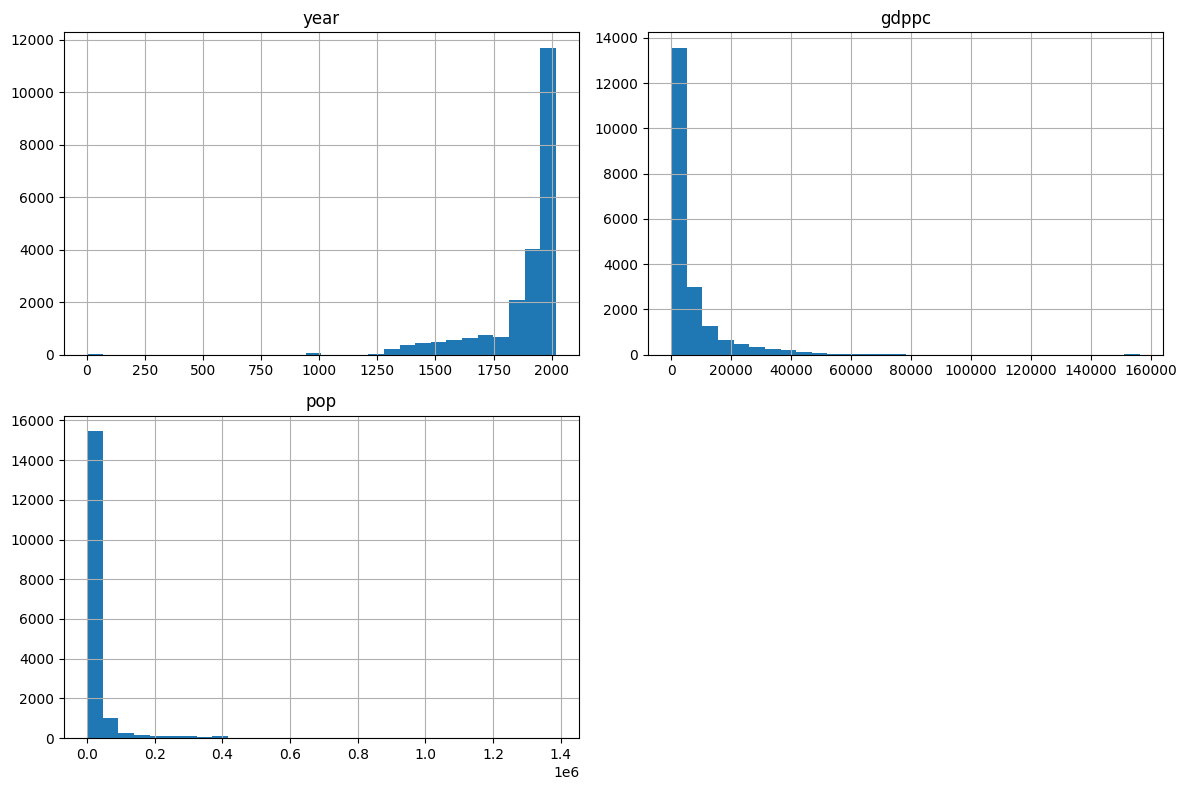

In [259]:
import matplotlib.pyplot as plt

df.select_dtypes(include="number").hist(figsize=(12, 8), bins=30)
plt.tight_layout()


In [260]:
# Distribución de columnas categóricas (frecuencias)
cat_cols = df.select_dtypes(include=["object", "category"]).columns

for col in cat_cols:
    print(f"\nDistribución de la columna: {col}")
    print(df[col].value_counts().head(10))



Distribución de la columna: countrycode
countrycode
GBR    786
SWE    732
FRA    729
ITA    724
NLD    677
POL    590
PRT    501
PER    433
MEX    380
ZAF    283
Name: count, dtype: int64

Distribución de la columna: country
country
United Kingdom    786
Sweden            732
France            729
Italy             724
Netherlands       677
Poland            590
Portugal          501
Peru              433
Mexico            380
South Africa      283
Name: count, dtype: int64


# 3. Limpieza y Normalización

## 3.1. Corrección de tipos.

Primero, cambio los tipos de las variables gdppc y pop, que deben ser numéricas. También hay que tener en cuenta que como separador de miles se está usando el espacio.

In [256]:
df['gdppc'] = df['gdppc'].str.replace('\xa0',"").astype('float32')
df['pop'] = df['pop'].str.replace('\xa0',"").astype('float32')
print(df.dtypes)

countrycode     object
country         object
year           float64
gdppc          float32
pop            float32
dtype: object


## 3.2. Tratamiento de nulos.

Primero, revisaré si hay una columna con demasiados valores faltantes (más del 40%) en tal caso la eliminaría.

In [261]:
cols_drop = null_percent[null_percent > 40].index.tolist()
print("Columnas eliminadas por exceso de nulos:", cols_drop)

df = df.drop(columns=cols_drop)

Columnas eliminadas por exceso de nulos: []


A continuación, buscaré filas duplicadas y eliminaré la fila que más valores faltantes tenga de las duplicadas que comparten identificador.

In [262]:
nan_counts = dups.isna().sum(axis=1)
idx_mejor = nan_counts.groupby([dups['countrycode'], dups['year']]).idxmin()
idx_a_borrar = dups.index.difference(idx_mejor)
df = df.drop(index=idx_a_borrar)
print(f"Filas eliminadas por duplicidad y valores faltantes: {len(idx_a_borrar)}")

Filas eliminadas por duplicidad y valores faltantes: 394


In [263]:
valores_nulos, null_counts, null_percent = valoresNulos()
print(valores_nulos)

             n_nulos  porcentaje_nulos
countrycode       57              0.26
country           57              0.26
year              49              0.22
gdppc           1989              9.13
pop             4498             20.64


## 3.3. Eliminación o tratamiento de duplicados.

El tratamiento de duplicado se ha realizado en el punto **3.2. Tratamiento de nulos.** pues los valores faltantes se ha usado de criterio para la eliminación de duplicados.

In [264]:
dups = df[df.duplicated(subset=['countrycode', 'year'], keep=False)] \
         .sort_values(['countrycode', 'year'])

print(dups)


Empty DataFrame
Columns: [countrycode, country, year, gdppc, pop]
Index: []


## 3.4. Normalización de categorías y Ffechas.

Me aseguro de que los países y sus respectivos códigos tengan el formato correcto.

In [265]:
cat_cols_limpias = []

if 'country' in df.columns:
    cat_cols_limpias.append('country')
if 'region' in df.columns:
    cat_cols_limpias.append('region')

for col in cat_cols_limpias:
    df[col] = (
        df[col]
        .astype('string')
        .str.strip()                       # quitar espacios al principio y final
        .str.replace(r'\s+', ' ', regex=True)  # colapsar espacios múltiples
        .str.title()                       # Primera letra en mayúscula
    )

# Normalizar códigos de país (mayúsculas y sin espacios)
if 'countrycode' in df.columns:
    df['countrycode'] = (
        df['countrycode']
        .astype('string')
        .str.strip()
        .str.upper()
    )


Ordeno el dataframe por país y año para mantener la coherencia temporal

In [ ]:
if 'countrycode' in df.columns:
    df = df.sort_values(['countrycode', 'year'])
else:
    df = df.sort_values(['year'])

# Comprobación rápida
print(df[['countrycode','year']].head() if 'countrycode' in df.columns else df['year'].head())


  countrycode    year
0         AFG  1820.0
1         AFG  1870.0
2         AFG  1913.0
3         AFG  1950.0
4         AFG  1951.0


# 4. Visualizaciones Básicas

# 5. Conclusiones Exploratorias